In [1]:
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from palindrome import check_palindrome
from tracr.haiku_to_pytorch import haiku_to_pytorch, apply

from dataloaders import makePalindromeDataLoader
from torchinfo import summary

In [2]:
loader = makePalindromeDataLoader()

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = check_palindrome()
torch_model = haiku_to_pytorch(model).to(DEVICE)

In [4]:
def evaluate(model, data):
    inputs, outputs = data[0]

    model_output = model.forward(inputs)

    if torch.isnan(sum(sum(sum(model_output)))):
        print(inputs)
        print(outputs)
        print(model_output)

    loss = F.cross_entropy(model_output, outputs)
    return loss, {
        "logits": model_output
    }

In [5]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         --
├─ModuleList: 1-1                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          8,343
│    │    └─TracrMLP: 3-2                31,696
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          8,343
│    │    └─TracrMLP: 3-4                31,696
│    └─TracrBlock: 2-3                   --
│    │    └─TracrAttention: 3-5          8,343
│    │    └─TracrMLP: 3-6                31,696
│    └─TracrBlock: 2-4                   --
│    │    └─TracrAttention: 3-7          8,343
│    │    └─TracrMLP: 3-8                31,696
Total params: 160,156
Trainable params: 160,156
Non-trainable params: 0

In [6]:
print(torch_model)

TracrTransformer(
  (layers): ModuleList(
    (0-3): 4 x TracrBlock(
      (attn): TracrAttention(
        (query): Linear(in_features=93, out_features=22, bias=True)
        (key): Linear(in_features=93, out_features=22, bias=True)
        (value): Linear(in_features=93, out_features=22, bias=True)
        (output): Linear(in_features=22, out_features=93, bias=True)
      )
      (mlp): TracrMLP(
        (linear1): Linear(in_features=93, out_features=169, bias=True)
        (linear2): Linear(in_features=169, out_features=93, bias=True)
      )
    )
  )
)


In [16]:
for _ in range(9):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader b

4.7


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


2.81


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.86it/s]


2.72


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


3.0


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


3.96


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


2.41


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


3.45


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


3.39


Chain 9: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]

2.72


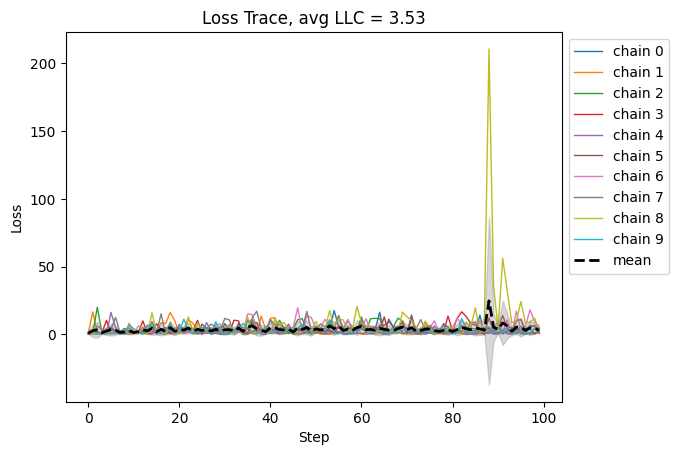

<Figure size 1200x900 with 0 Axes>

In [9]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)